# Testing for Peak Integration in Python using Derivative Spectra



## Preliminary on Spectral Line Shapes


### Lorentzian

Given by $L = \frac{1}{1+x^2}$

Variable $x$ is defined by $x = \frac{p-p_0}{\omega /2}$

+ $p_0$ Position of the Maximum
+ $p$ ... Position
+ $\omega$ ... Full WIdth at Half Maximum

### Gaussian 

$f(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x- \mu)^2}{2\sigma^2}}$

With $\mu$ expectation value and $\sigma^2$ variance.


Some useful symmetries and derivatives:

+ Unimodal: first derivative is positive for $x < \mu$ and negative for $ x > \mu$
+ First Derivative $f'(x) = - \frac{x-\mu}{\sigma^2}f(x)$
+ Second Derivative $f''(x) = \frac{(x-\mu)^2 - \sigma^2}{\sigma^4}f(x)$


### Voigt

Convolution of Gaussian and Lorentzian Function given by:

$V(x,\sigma,\gamma)= \int_{-\infty}^{\infty}G(x';\sigma)L(x-x';\gamma)dx'$





In [184]:
# Modules Import

import numpy as np
from scipy import signal
from scipy.ndimage import shift
import matplotlib.pyplot as plt

Note for a Gaussian Peak we have the Integral:

$\int_{-\infty}^{\infty} a e^{-(x-b)²/2c^2}dx = ac*\sqrt{2\pi}$

So in this test phase we can directly influence our intensity by multiplying with an arbitrary Parameter $a$

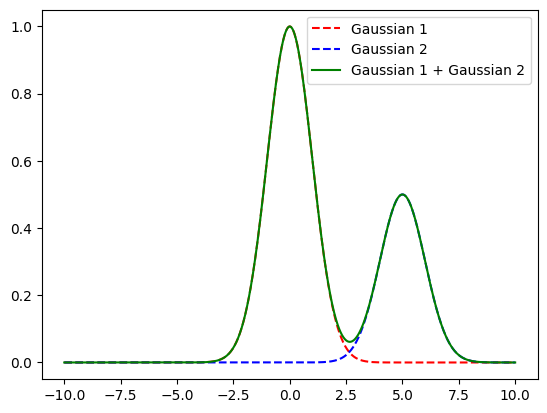

In [185]:
def gaussian(x,mean,std_dev,intensity):
    return intensity*np.exp(-(x--mean)**2/(2*std_dev**2))


x = np.linspace(-10,10,1000)

mean,std_dev,intensity = 0,1,1
mean2,std_dev2,intensity2 = 0,1,0.5

shift_horizontal = 5

y1 = gaussian(x,mean,std_dev,intensity)
y2 = gaussian(x-shift_horizontal,mean2,std_dev2,intensity2)

y_total = y1 + y2

plt.plot(x,y1,label='Gaussian 1', color = "red", linestyle = "--")
plt.plot(x,y2,label='Gaussian 2', color = "blue", linestyle = "--")
plt.plot(x,y_total ,label='Gaussian 1 + Gaussian 2', color = "green")
plt.legend()
plt.show()

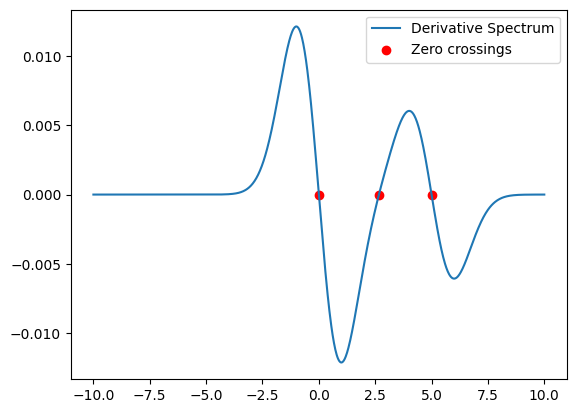

In [186]:
# Calculate the Derivative Spetrum

y_prime = np.gradient(y_total)

def derivative_spectrum(y_data):
    """ 
    Calculates the Numerical Derivative using the gradient
    """
    return np.gradient(y_data)

def find_zero_crossing_lin_int(x_data, y_prime, tol = 1e-5):
    """ 
    Finds zero crossing in the given derivative spectrum

    For this we use a linear interpolation approach (i.e sign change yi yi-1 <0)
    """

    zero_crossings = []
    zero_crossings_indices = []
    for i in range(1,len(y_prime)):
        if y_prime[i-1] * y_prime[i] < 0:
            zero_crossing = x_data[i-1] - y_prime[i-1] * (x_data[i] - x_data[i-1])/ (y_prime[i] - y_prime[i-1])
            zero_crossings.append(zero_crossing)
            zero_crossings_indices.append(i)
    return zero_crossings, zero_crossings_indices

zero_crossings, zero_crossings_indices = find_zero_crossing_lin_int(x,y_prime)


plt.plot(x,y_prime, label="Derivative Spectrum")
plt.scatter(zero_crossings, np.zeros_like(zero_crossings), color = "red", label="Zero crossings")
plt.legend()
plt.show()




# Some Integration Tests

We can compute the left and right area using the zero crossing of the peak. We dann use a optimizer function to find the correct shift between the two areas

0.0038224489964678865
0.003749827006871792
-0.0008360257625040293
-0.0011272058580505395
-0.0010920930587249161
-0.0011258934291111002
-0.0011427835494887337
-0.0011391798587711208
-0.0011431258264777283
-0.0011445944951568691
-0.0011444595497465508
-0.0011448589183248592
-0.0011448416572846648
-0.0011449353853495783
-0.0011449528818750776
-0.0011449737270243024
-0.0011449846979234395
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995


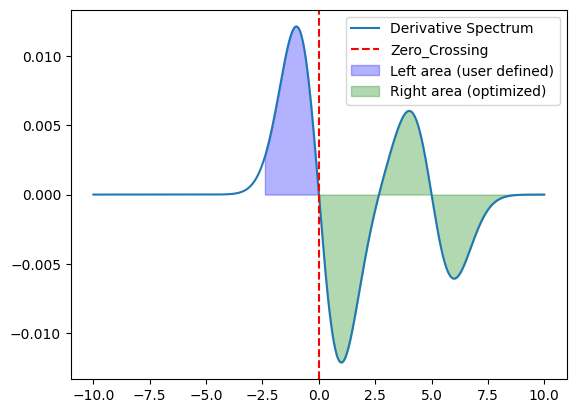

In [187]:
# First of find the x data that is most close to the zero crossing
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
def balance_area_spectrum(x,y_prime,left_boundary_index,zero_crossing, right_boundary_index=None):
    """
    A function to balance the areas in the derivative spectrum around the zero crossing 
    """

    if left_boundary_index >=zero_crossing:
        raise ValueError("Left Boundary must be before the zero crossing")
    

    x_left = x[left_boundary_index:zero_crossing+1]
    y_left = y_prime[left_boundary_index:zero_crossing +1]

    left_area = np.trapz(y_left,x_left)

    def balance_areas(shift_idx):

        shifted_right_idx = zero_crossing + int(shift_idx)
        if shifted_right_idx >= len(x):
            return np.inf # Prevent out of bounds
        
        x_shifted_right = x[zero_crossing:shifted_right_idx + 1]
        y_shifted_right = y_prime[zero_crossing:shifted_right_idx + 1]


        
        right_area = np.trapz(y_shifted_right,x_shifted_right)
        
        # End the closure to give back the diverence in areas
        print(np.abs(left_area) - np.abs(right_area))
        return np.abs(left_area) - np.abs(right_area)
    
    result = minimize_scalar(balance_areas, bounds = (0, len(x)- zero_crossing), method="bounded")

    optimal_shift = int(result.x)

    x_balanced_right = x[zero_crossing:zero_crossing + optimal_shift +1]
    y_balanced_right = y_prime[zero_crossing:zero_crossing + optimal_shift + 1]

    balanced_right_area = np.trapz(y_balanced_right,x_balanced_right)

    plt.plot(x,y_prime, label="Derivative Spectrum")
    plt.axvline(x=x[zero_crossing], color = "r", linestyle="--",label="Zero_Crossing")
    plt.fill_between(x_left,y_left,color="blue", alpha=0.3, label="Left area (user defined)")
    plt.fill_between(x_balanced_right,y_balanced_right,color="green",alpha=0.3, label="Right area (optimized)")
    plt.legend()
    plt.show()


    
balance_area_spectrum(x,y_prime, 380, zero_crossings_indices[0])

0.0015635259855179308
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56353D-03    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   1.564D-03
  F =   1.5635259855179308E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


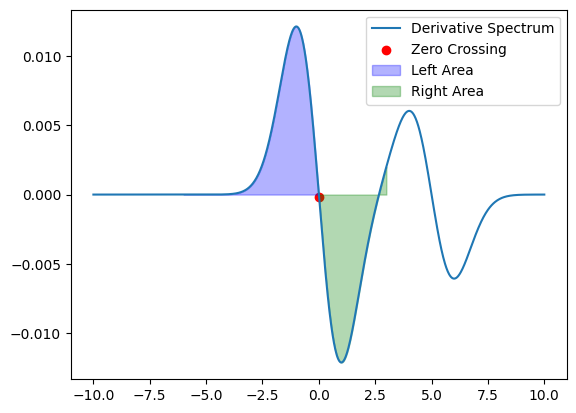

In [188]:
# ok new try use minimizer algorithm

from scipy.optimize import minimize



def area_difference(right_bound, x,y_prime, left_bound, zero_crossing):
    right_bound = int(right_bound[0])

    left_area = np.trapz(y_prime[left_bound:zero_crossing], x[left_bound:zero_crossing])
    right_area = np.trapz(y_prime[zero_crossing:right_bound], x[zero_crossing:right_bound])

    return np.abs(left_area) - np.abs(right_area)

left_bound = 200
zero_crossing = zero_crossings_indices[0]
initial_right_bound = 650

def callbackF(xk):
    print("Current Right bound: ", xk)

result = minimize(area_difference,x0=[initial_right_bound], args=(x,y_prime,left_bound, zero_crossing), 
                  bounds=[(zero_crossing,len(x)-1)],method="L-BFGS-B",options={"eps":1e-2,"disp":True},callback=callbackF)

print(result.fun)

# Ergebnis der Minimierung
right_bound = int(result.x[0])

# Plotten des Ableitungsspektrums und Markieren der Nullstellen
plt.plot(x, y_prime, label="Derivative Spectrum")
plt.scatter(x[zero_crossing], y_prime[zero_crossing], color="red", label="Zero Crossing")

# Markieren der Bereiche mit fill_between
plt.fill_between(x[left_bound:zero_crossing], y_prime[left_bound:zero_crossing], color='blue', alpha=0.3, label='Left Area')
plt.fill_between(x[zero_crossing:right_bound], y_prime[zero_crossing:right_bound], color='green', alpha=0.3, label='Right Area')

plt.legend()
plt.show()





634


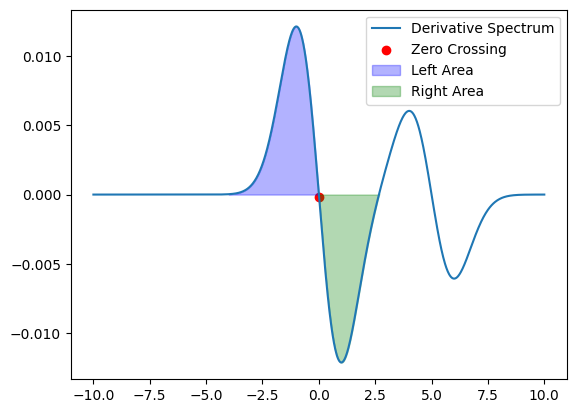

In [189]:
# Lets try a manual optimization


def area_difference(right_bound, x,y_prime, left_bound, zero_crossing):
    right_bound = int(right_bound)

    left_area = np.trapz(y_prime[left_bound:zero_crossing], x[left_bound:zero_crossing])
    right_area = np.trapz(y_prime[zero_crossing:right_bound], x[zero_crossing:right_bound])

    return np.abs(left_area) - np.abs(right_area)


left_bound = 300
zero_crossing = zero_crossings_indices[0]
initial_right_bound = 550
user_top_bound = 700

best_right_bound = initial_right_bound
best_area_diff = area_difference(initial_right_bound,x,y_prime,left_bound,zero_crossing)

step_size=1


for right_bound in range(initial_right_bound, user_top_bound, step_size):
    current_area_diff = area_difference(right_bound,x,y_prime, left_bound, zero_crossing)
    if current_area_diff < best_area_diff:
        best_area_diff = current_area_diff
        best_right_bound = right_bound

right_bound = best_right_bound

print(right_bound)

# Plotten des Ableitungsspektrums und Markieren der Nullstellen
plt.plot(x, y_prime, label="Derivative Spectrum")
plt.scatter(x[zero_crossing], y_prime[zero_crossing], color="red", label="Zero Crossing")

# Markieren der Bereiche mit fill_between
plt.fill_between(x[left_bound:zero_crossing], y_prime[left_bound:zero_crossing], color='blue', alpha=0.3, label='Left Area')
plt.fill_between(x[zero_crossing:right_bound], y_prime[zero_crossing:right_bound], color='green', alpha=0.3, label='Right Area')

plt.legend()
plt.show()



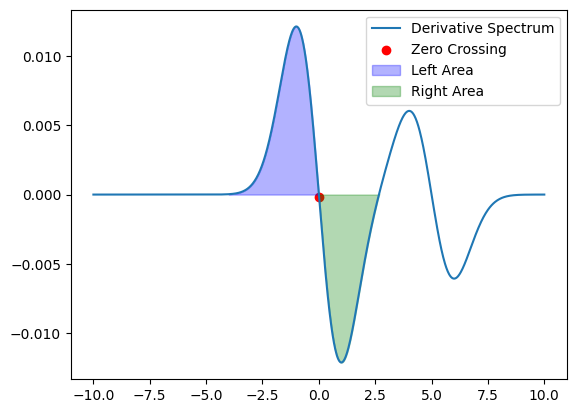

634

In [190]:
def optimize_and_plot(x, y_prime, left_bound, zero_crossings_indices, idx_zero_crossing, initial_right_bound, user_top_bound, step_size=1):
    """ 
    Performs a optimization of a given are around a zero crossing in the derivative spectrum

    Attr:
        x: x data points
        y_prime: numerical derivative of the data
        left_bound: user defined left boundard near the zero crossing
        zero_crossing_indices: a list of possible zero crossings in the derivative spectrum
        idx_zero_crossings: the index of the zero crossing we want to look at
        initial_right_bound: the initial guess for the right bound which we want optimize
        user_top_bound: a top upper bound (TODO: eliminate this attribute with further constraints)
        step_size: the step size for the optimization (check with real spectrum)
    """
    def area_difference(right_bound, x, y_prime, left_bound, zero_crossing):
        right_bound = int(right_bound)
        left_area = np.trapz(y_prime[left_bound:zero_crossing], x[left_bound:zero_crossing])
        right_area = np.trapz(y_prime[zero_crossing:right_bound], x[zero_crossing:right_bound])
        return np.abs(left_area) - np.abs(right_area)

    zero_crossing = zero_crossings_indices[idx_zero_crossing]
    best_right_bound = initial_right_bound
    best_area_diff = area_difference(initial_right_bound, x, y_prime, left_bound, zero_crossing)

    for right_bound in range(initial_right_bound, user_top_bound, step_size):
        current_area_diff = area_difference(right_bound, x, y_prime, left_bound, zero_crossing)
        if current_area_diff < best_area_diff:
            best_area_diff = current_area_diff
            best_right_bound = right_bound

    right_bound = best_right_bound
    

    # Plotting the derivative spectrum and marking the zero crossings
    plt.plot(x, y_prime, label="Derivative Spectrum")
    plt.scatter(x[zero_crossing], y_prime[zero_crossing], color="red", label="Zero Crossing")

    # Marking the areas with fill_between
    plt.fill_between(x[left_bound:zero_crossing], y_prime[left_bound:zero_crossing], color='blue', alpha=0.3, label='Left Area')
    plt.fill_between(x[zero_crossing:right_bound], y_prime[zero_crossing:right_bound], color='green', alpha=0.3, label='Right Area')

    plt.legend()
    plt.show()

    return right_bound

optimize_and_plot(x, y_prime, 300, zero_crossings_indices,0, 550, 700, 1)

Before we do the integration we have to implement the procedure for optimizing the left and also the right bound

In [191]:
def optimize_and_plot(x, y_prime, zero_crossings_indices, idx_zero_crossing, initial_bound, user_bound, bound_type='right', step_size=1):
    """ 
    Performs an optimization of a given area around a zero crossing in the derivative spectrum.

    Attr:
        x: x data points
        y_prime: numerical derivative of the data
        zero_crossing_indices: a list of possible zero crossings in the derivative spectrum
        idx_zero_crossing: the index of the zero crossing we want to look at
        initial_bound: the initial guess for the bound which we want to optimize
        user_bound: a user-defined bound (upper or lower depending on bound_type)
        bound_type: 'right' to optimize the right bound, 'left' to optimize the left bound
        step_size: the step size for the optimization (check with real spectrum)
    """
    def area_difference(left_bound, right_bound, x, y_prime, zero_crossing):
        left_area = np.trapz(y_prime[left_bound:zero_crossing], x[left_bound:zero_crossing])
        right_area = np.trapz(y_prime[zero_crossing:right_bound], x[zero_crossing:right_bound])
        return np.abs(left_area) - np.abs(right_area)

    zero_crossing = zero_crossings_indices[idx_zero_crossing]

    if bound_type == 'right':
        left_bound = initial_bound
        best_bound = initial_bound
        best_area_diff = area_difference(left_bound, initial_bound, x, y_prime, zero_crossing)

        for bound in range(initial_bound, user_bound, step_size):
            current_area_diff = area_difference(left_bound, bound, x, y_prime, zero_crossing)
            if np.abs(current_area_diff) < np.abs(best_area_diff):
                best_area_diff = current_area_diff
                best_bound = bound

        right_bound = best_bound
        left_bound = initial_bound

    elif bound_type == 'left':
        right_bound = initial_bound
        best_bound = initial_bound
        best_area_diff = area_difference(initial_bound, right_bound, x, y_prime, zero_crossing)

        for bound in range(initial_bound, user_bound, -step_size):
            current_area_diff = area_difference(bound, right_bound, x, y_prime, zero_crossing)
            if np.abs(current_area_diff) < np.abs(best_area_diff):
                best_area_diff = current_area_diff
                best_bound = bound

        left_bound = best_bound
        right_bound = initial_bound

    else:
        raise ValueError("Invalid bound_type. Use 'right' or 'left'.")

    # Plotting the derivative spectrum and marking the zero crossings
    plt.plot(x, y_prime, label="Derivative Spectrum")
    plt.scatter(x[zero_crossing], y_prime[zero_crossing], color="red", label="Zero Crossing")

    # Marking the areas with fill_between
    plt.fill_between(x[left_bound:zero_crossing], y_prime[left_bound:zero_crossing], color='blue', alpha=0.3, label='Left Area')
    plt.fill_between(x[zero_crossing:right_bound], y_prime[zero_crossing:right_bound], color='green', alpha=0.3, label='Right Area')

    plt.legend()
    plt.show()

    return left_bound, right_bound

# Back integration

Now lets use the bound we calculated to get the total area of the initial Gauss peak

+ So we have a function that optimizes the other integration bound given the first one
+ We can now use this to deconvolute the are of these peaks

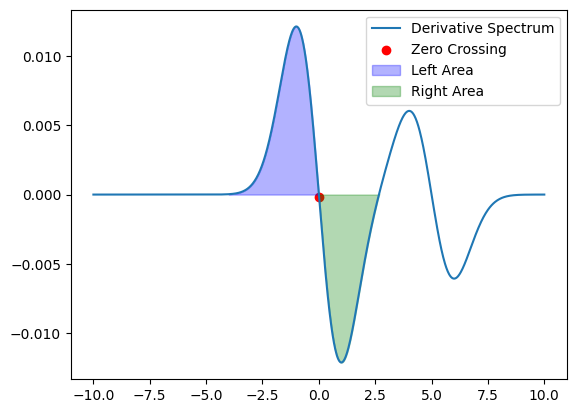

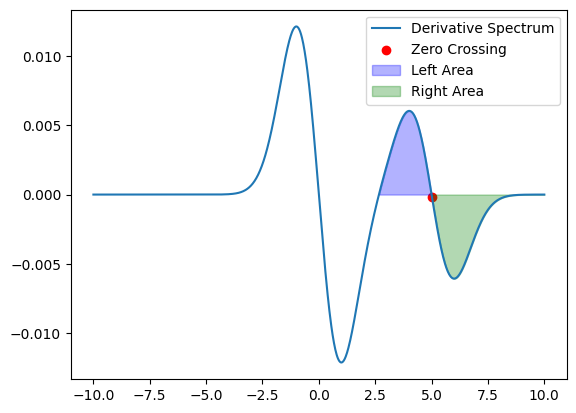

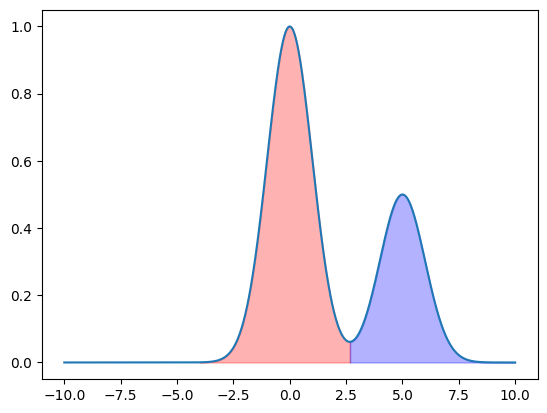

In [192]:
left_bound_1,right_bound_1 = optimize_and_plot(x, y_prime, zero_crossings_indices, 0, 300, 800, 'right', 1)

# for the second peak we take the left bound as a optimization parameter

left_bound_2,right_bound_2 = optimize_and_plot(x, y_prime, zero_crossings_indices, 2, 1000, 600, 'left', 1)

plt.plot(x,y_total, label="Original Data")
plt.fill_between(x[left_bound_1:right_bound_1],y_total[left_bound_1:right_bound_1],color="red",alpha=0.3, label="Selected Area")
plt.fill_between(x[left_bound_2:right_bound_2],y_total[left_bound_2:right_bound_2],color="blue",alpha=0.3, label="Selected Area")


In [193]:
# Calculate the areas using this integration bounds

area_1 = np.trapz(y_total[left_bound_1:right_bound_1],x[left_bound_1:right_bound_1])
area_2 = np.trapz(y_total[left_bound_2:right_bound_2],x[left_bound_2:right_bound_2])

print("Area 1: ", area_1)
print("Area 2: ", area_2)
print("Intensity Ratio: ", area_2/area_1)


Area 1:  2.509616201032215
Area 2:  1.2502443782995627
Intensity Ratio:  0.49818150591525995


# More Noise Signal



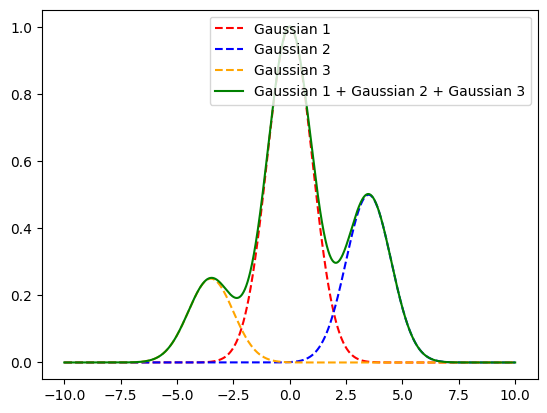

In [194]:
x = np.linspace(-10,10,1000)

mean,std_dev,intensity = 0,1,1
mean2,std_dev2,intensity2 = 0,1,0.5
mean3,std_dev3,intensity3 = 0,1,0.25


shift_horizontal = 3.5

y1 = gaussian(x,mean,std_dev,intensity)
y2 = gaussian(x-shift_horizontal,mean2,std_dev2,intensity2)
y3 =  gaussian(x+shift_horizontal,mean3,std_dev3,intensity3)

y_total = y1 + y2 + y3


plt.plot(x,y1,label='Gaussian 1', color = "red", linestyle = "--")
plt.plot(x,y2,label='Gaussian 2', color = "blue", linestyle = "--")
plt.plot(x,y3,label='Gaussian 3', color = "orange", linestyle = "--")
plt.plot(x,y1+y2+y3,label='Gaussian 1 + Gaussian 2 + Gaussian 3', color = "green")
plt.legend()

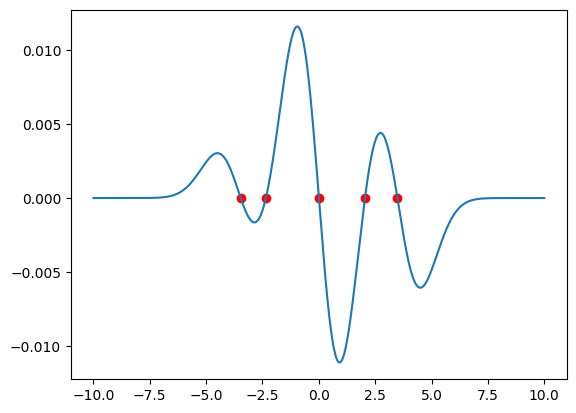

In [195]:
# calculate derivative spectrum and zero crossings

y_prime = derivative_spectrum(y_total)
zero_crossings, zero_crossings_indices = find_zero_crossing_lin_int(x,y_prime)

plt.plot(x,y_prime, label="Derivative Spectrum")
plt.scatter(zero_crossings, np.zeros_like(zero_crossings), color = "red", label="Zero crossings")

[327, 383, 500, 602, 674]


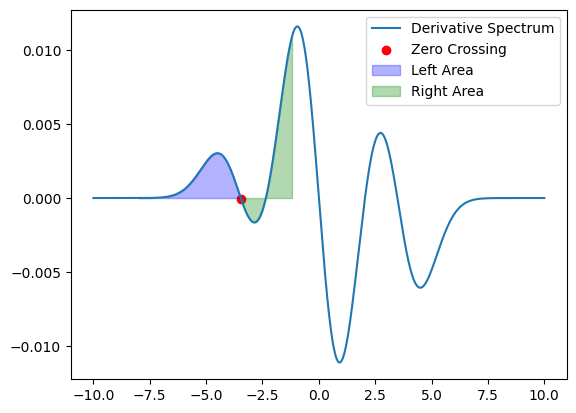

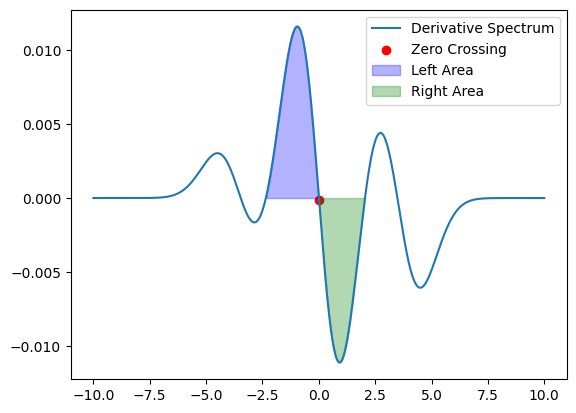

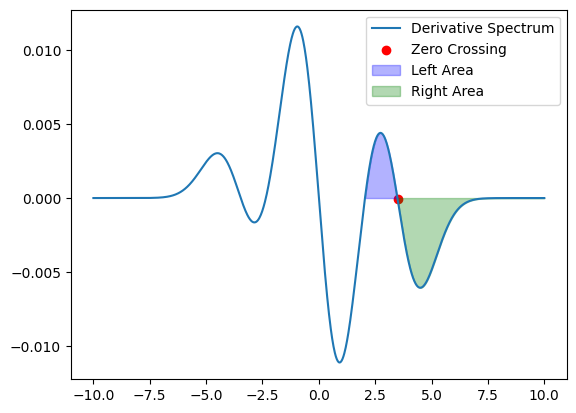

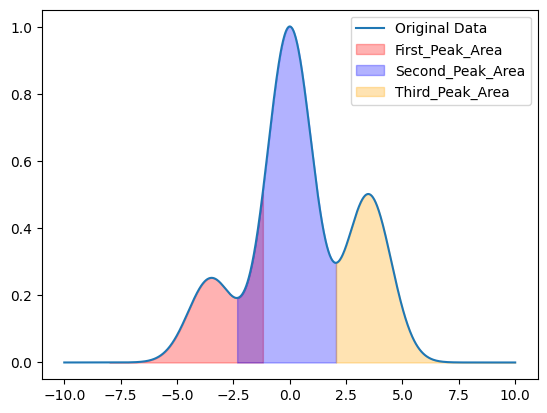

In [196]:
# Optimize the areas of all zero crossings
print(zero_crossings_indices)
left_bound_1,right_bound_1 = optimize_and_plot(x, y_prime, zero_crossings_indices, 0, 100, 450, 'right', 1)
left_bound_2,right_bound_2 = optimize_and_plot(x, y_prime, zero_crossings_indices, 2, zero_crossings_indices[1], 700, 'right', 1)
left_bound_3,right_bound_3 = optimize_and_plot(x, y_prime, zero_crossings_indices, 4, 1000, 550, 'left', 1)

plt.plot(x,y_total, label="Original Data")
plt.fill_between(x[left_bound_1:right_bound_1],y_total[left_bound_1:right_bound_1],color="red",alpha=0.3, label="First_Peak_Area")
plt.fill_between(x[left_bound_2:right_bound_2],y_total[left_bound_2:right_bound_2],color="blue",alpha=0.3, label="Second_Peak_Area")
plt.fill_between(x[left_bound_3:right_bound_3],y_total[left_bound_3:right_bound_3],color="orange",alpha=0.3, label="Third_Peak_Area")
plt.legend()
plt.show()

In [197]:
peak_1 = np.trapz(y_total[left_bound_1:right_bound_1],x[left_bound_1:right_bound_1])
peak_2 = np.trapz(y_total[left_bound_2:right_bound_2],x[left_bound_2:right_bound_2])
peak_3 = np.trapz(y_total[left_bound_3:right_bound_3],x[left_bound_3:right_bound_3])

print("Peak 1: ", peak_1)
print("Peak 2: ", peak_2)
print("Peak 3: ", peak_3)
print("Ration 1/2: ", peak_1/peak_2)
print("Ratio 2/3: ", peak_3/peak_2)

Peak 1:  0.9128565868427312
Peak 2:  2.6002547624159225
Peak 3:  1.21113849193691
Ration 1/2:  0.35106428802175793
Ratio 2/3:  0.46577685749977404


Not to bad, but  what do we do with super noisy data, we have to use some kind of interpolation method


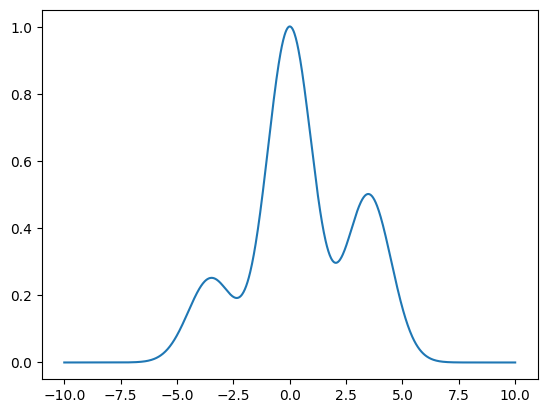

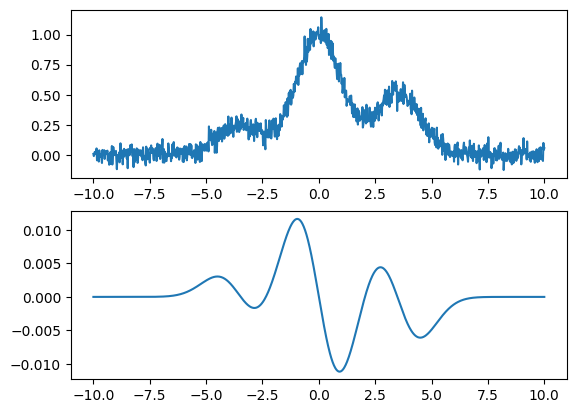

In [198]:
plt.plot(x,y_total, label="Original Data")
plt.show()


# Adding Noise
noise_level = 0.05

noise = noise_level * np.random.normal(size=y_total.shape)

y_total_noisy = y_total + noise

y_prime = derivative_spectrum(y_total)
plt.subplot(2,1,1)
plt.plot(x,y_total_noisy, label="Added Noise")
plt.subplot(2,1,2)
plt.plot(x,y_prime, label="Derivative Spectrum")
plt.show()


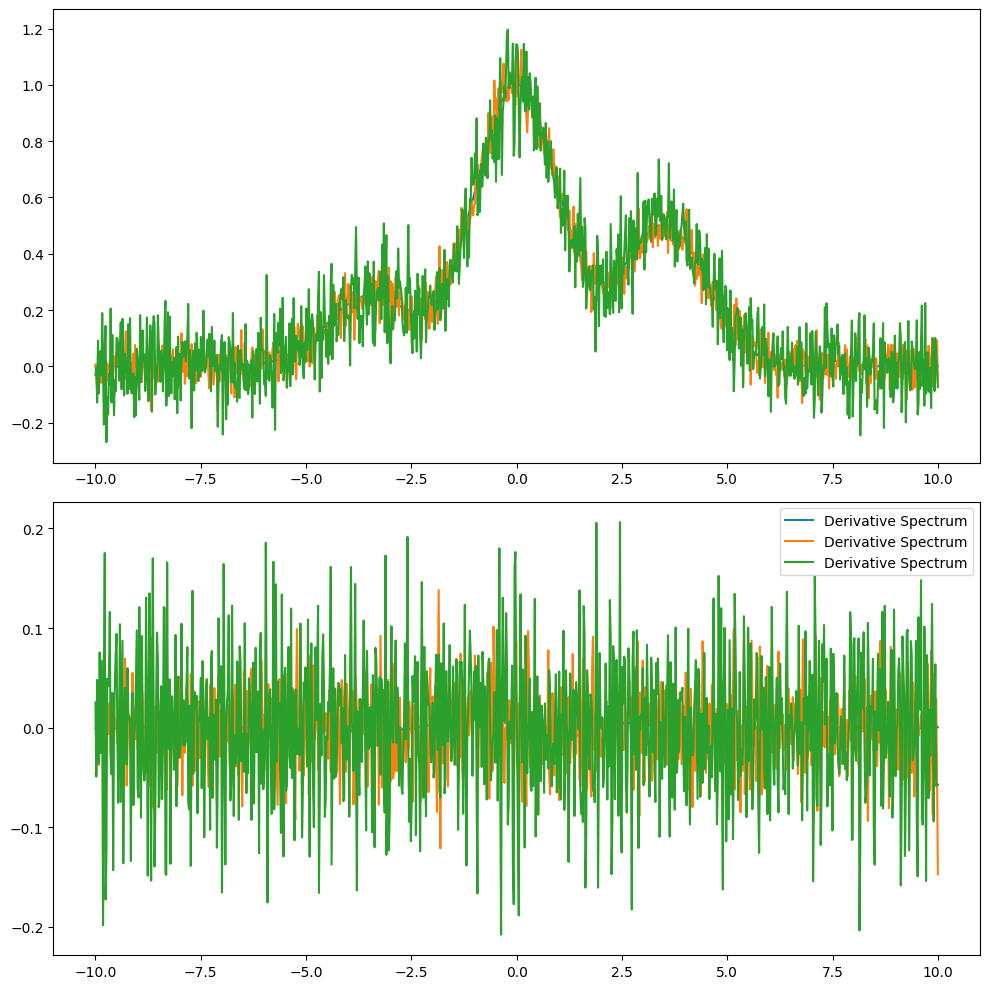

In [201]:
noise_levels = [0.001,0.05,0.1]

plt.figure(figsize=(10,10))

for noise_level in noise_levels:

    # Add noise to data
    noise = noise_level* np.random.normal(size=y_total.shape)
    y_total_noisy = y_total + noise

    # Calculate the derivative spectrum
    y_prime = derivative_spectrum(y_total_noisy)
    
    plt.subplot(2,1,1)
    plt.plot(x,y_total_noisy, label="Noise Level: " + str(noise_level))
    plt.subplot(2,1,2)
    plt.plot(x,y_prime, label="Derivative Spectrum")
plt.legend()
plt.tight_layout()
plt.show()